In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, precision_recall_curve, auc, precision_score,
                             PrecisionRecallDisplay, RocCurveDisplay)


def get_score(X, y, random_seed=42, model=None, metrics=['CR', 'CM', 'ROC', 'PR'], is_return=False):
   ''' Функция для обучения модели и подсчета метрик качества '''
   
   if model is None:
    model = LogisticRegression()

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                       stratify=y, random_state=random_seed)
  
  # стандартизация данных
   scaler = StandardScaler()
   X_train = scaler.fit_transform(X_train)
   X_test = scaler.transform(X_test)

  # обучение и предсказание
   model.fit(X_train, y_train)
   pred_train = model.predict(X_train)
   pred_test = model.predict(X_test)
   pred_proba_test = model.predict_proba(X_test)

  # вывод метрик качества
   if 'CR' in metrics:
    print('Отчет о классификации для тренировочных данных:\n' + 
          classification_report(y_train, pred_train) + '\n')
    print('Отчет о классификации для тестовых данных:\n' + 
          classification_report(y_test, pred_test) + '\n')
   
   # матрица ошибок
   if 'CM' in metrics:
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title('Матрица ошибок');
   
   # ROC-кривая
   if 'ROC' in metrics:
    fpr, tpr, _ = roc_curve(y_test, pred_proba_test[:, 1])
    display = RocCurveDisplay(fpr=fpr, tpr=tpr
                            , roc_auc=auc(fpr, tpr)
                            , estimator_name='LogisticRegression')
    display.plot()
    plt.grid(True, alpha=.3)
    plt.title('ROC-кривая');

   # PR-кривая
   if 'PR' in metrics:
    pr, r, _ = precision_recall_curve(y_test, pred_proba_test[:, 1])

    display = PrecisionRecallDisplay(precision=pr, recall=r
                                  , average_precision=precision_score(y_test, pred_test)
                                  , estimator_name='LogisticRegression')
    display.plot()
    plt.title("PR-кривая")
    plt.grid(True, alpha=.3);
   
   if is_return:
     return model
   


## 0. Загрузка данных

In [3]:
df = pd.read_csv('../content/salary.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1. Базовое решение

### 1.1 Минимальные преобразования

In [4]:
# посмотрим на целевой признак

df['salary'].value_counts()

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
num_features = list(df.select_dtypes(['int64']).columns)
cat_features = list(df.select_dtypes(['object']).columns.drop('salary'))
target_feature = 'salary'

In [7]:
# в виду того, что целевой признак по сути бинарный, закдируем его 0 и 1

df.loc[df['salary'] == ' <=50K', 'salary'] = 0
df.loc[df['salary'] == ' >50K', 'salary'] = 1
df['salary'] = df['salary'].astype('int')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


### 1.2 Обучение модели и подсчет метрик

Отчет о классификации для тренировочных данных:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     18539
           1       0.71      0.39      0.50      5881

    accuracy                           0.81     24420
   macro avg       0.77      0.67      0.69     24420
weighted avg       0.80      0.81      0.79     24420


Отчет о классификации для тестовых данных:
              precision    recall  f1-score   support

           0       0.83      0.94      0.89      6181
           1       0.70      0.41      0.52      1960

    accuracy                           0.82      8141
   macro avg       0.77      0.68      0.70      8141
weighted avg       0.80      0.82      0.80      8141




<Figure size 1200x1000 with 0 Axes>

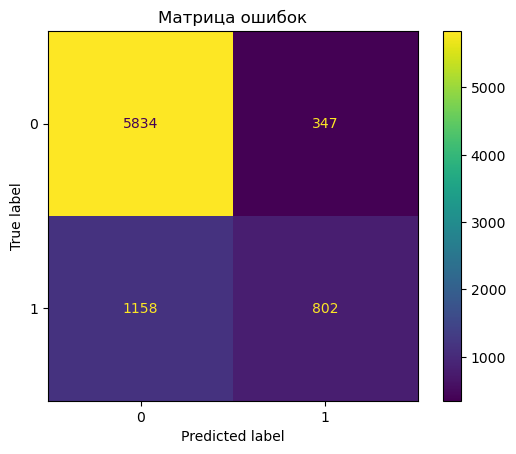

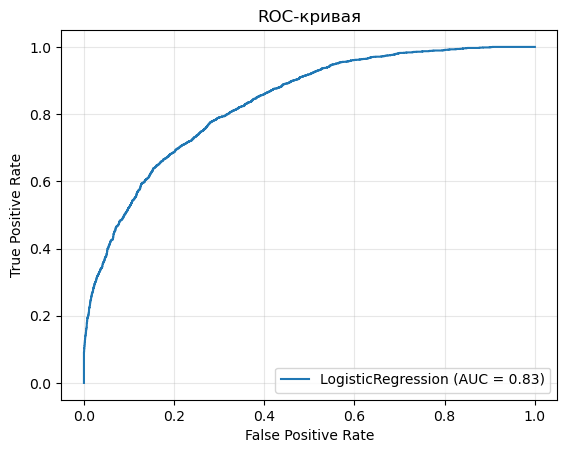

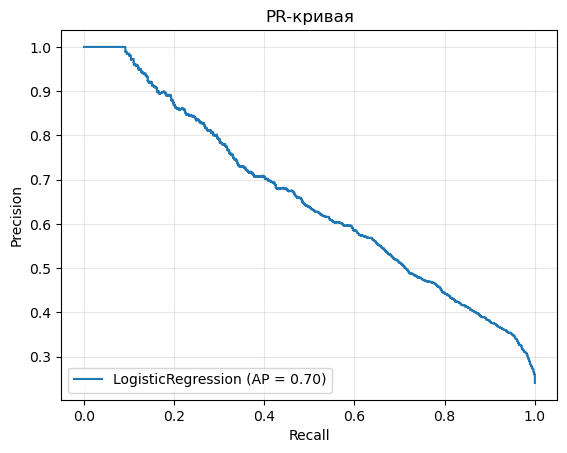

In [8]:
get_score(df[num_features], df[target_feature])

## 2. Первичный и визуальный анализ данных

В датасете 32 561 наблюдение, 15 признаков: 6 вещественных и 9 категориальных. Пропусков нет

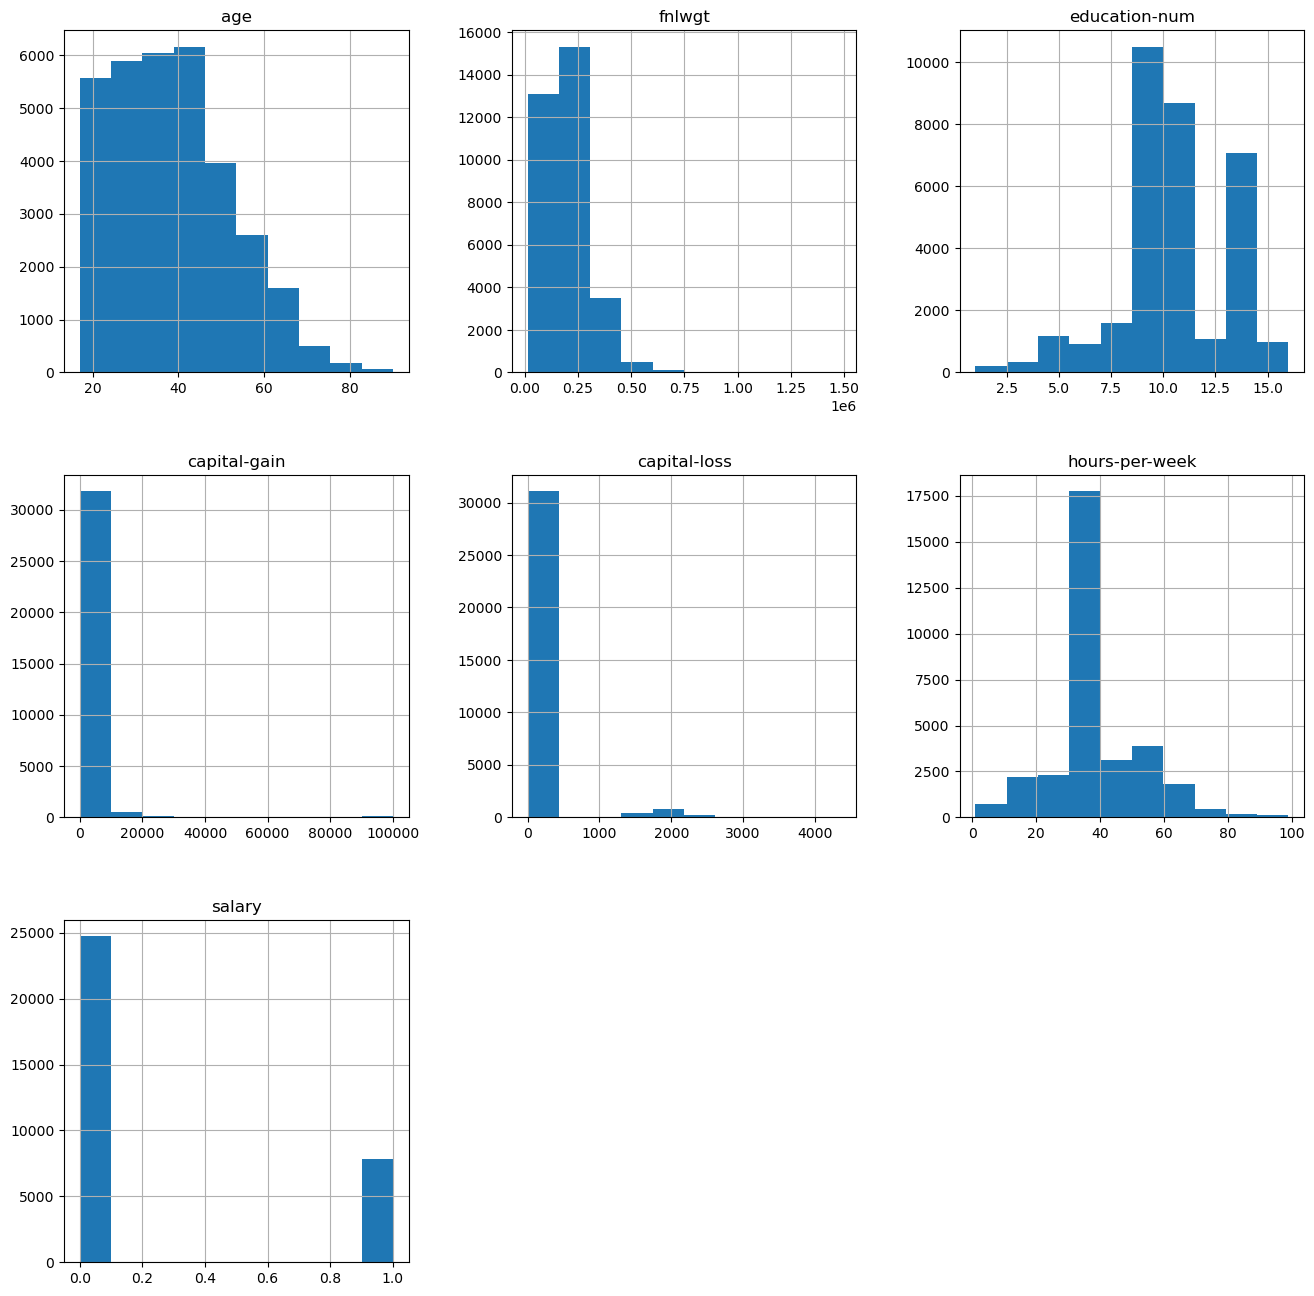

In [9]:
# вещественные признаки

df.hist(figsize=(16, 16));

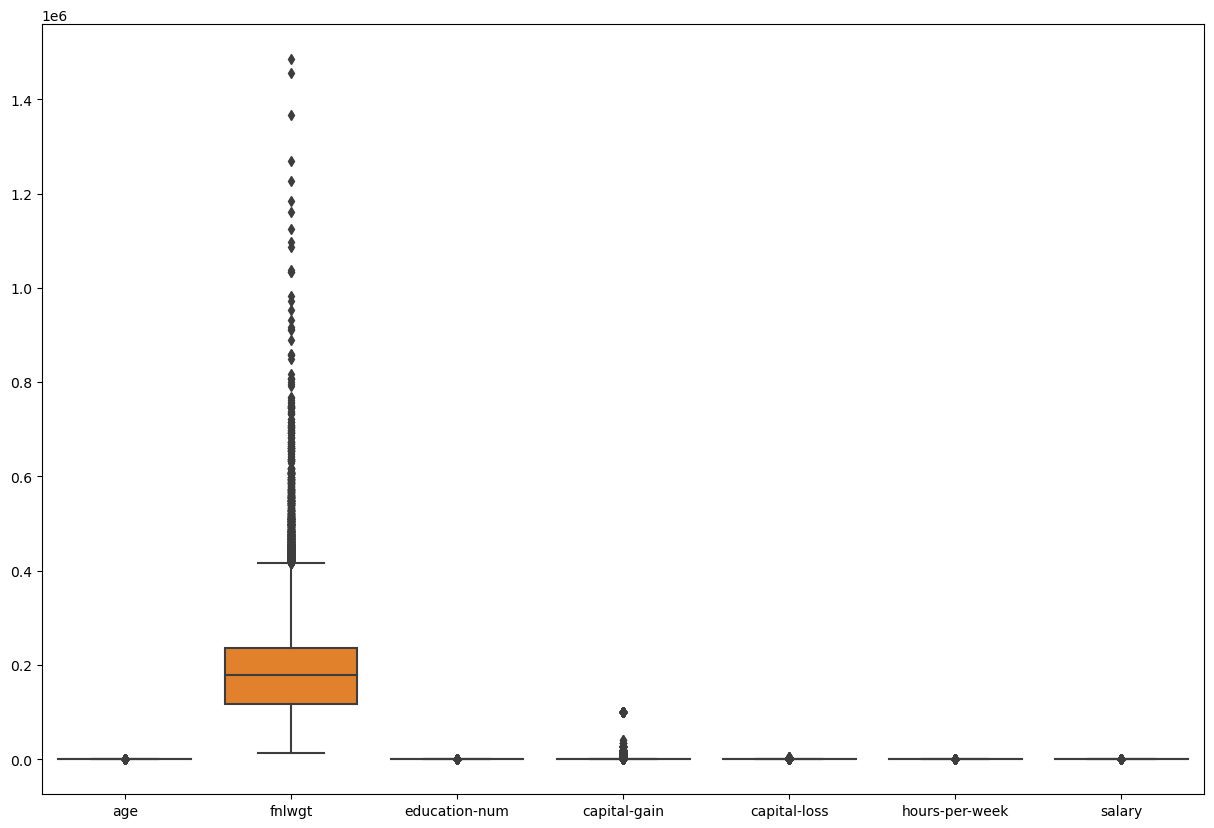

In [10]:
plt.figure(figsize=(15, 10))
sns.boxplot(df);

Все вещественные признаки имеют выбросы, но явнее всего они выражены в признаке `fnlwgt`

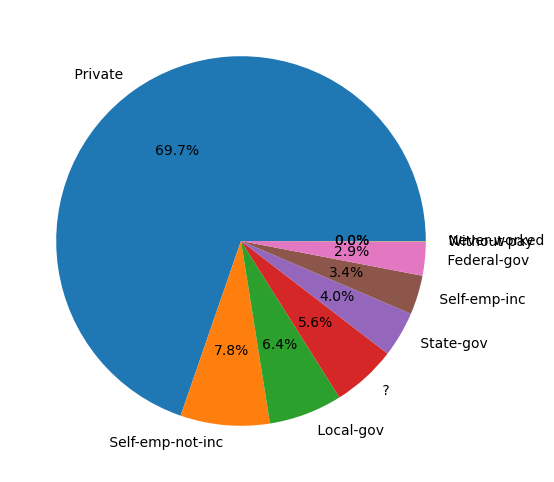

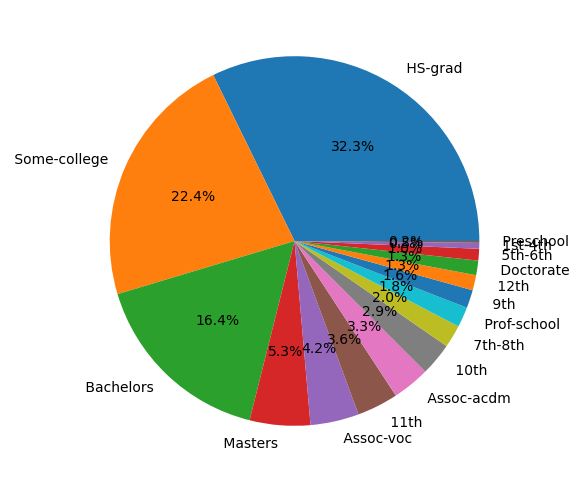

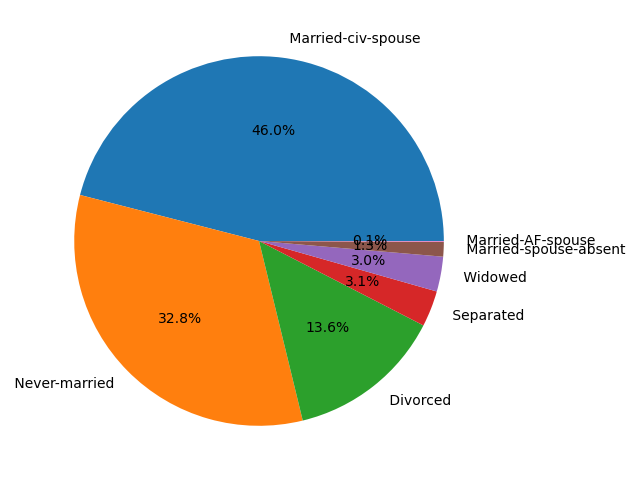

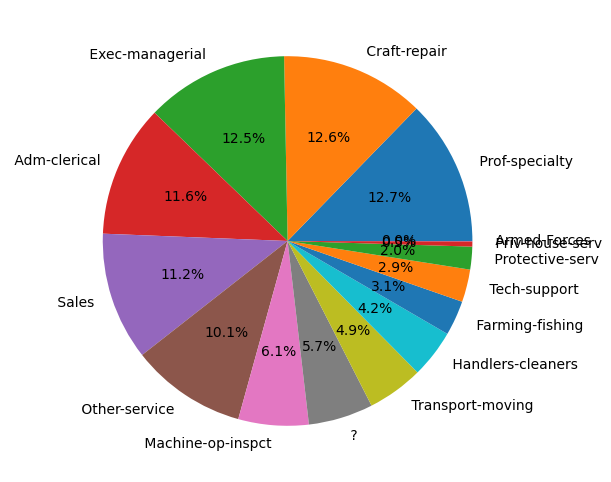

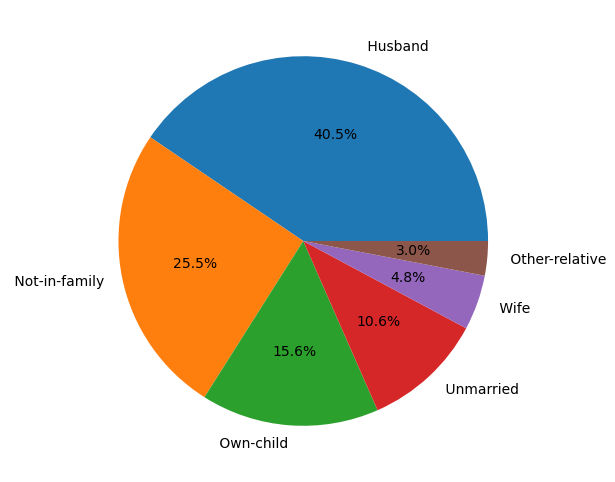

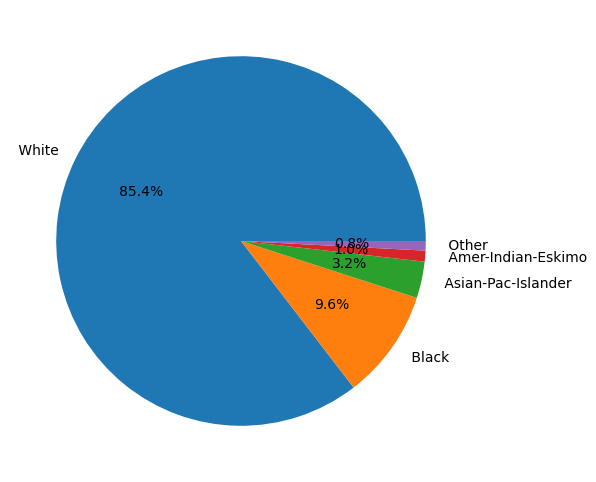

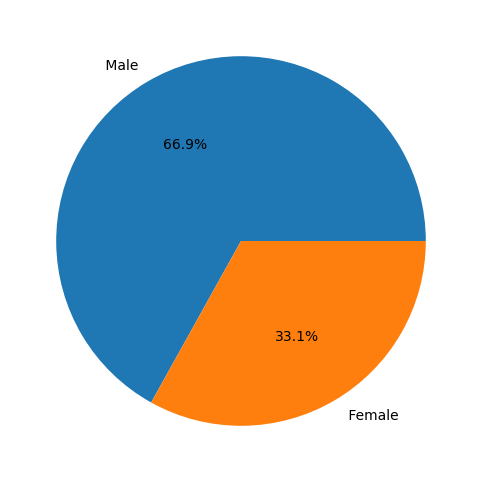

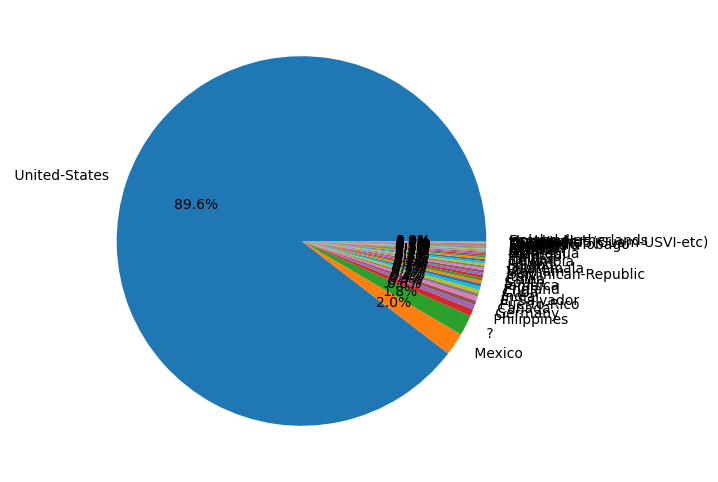

In [11]:
# категориальные признаки

for cat_feature in cat_features:

    df_to_pie = df[cat_feature].value_counts()

    plt.figure(figsize=(8, 6))
    plt.pie(df_to_pie.values
            , labels=df_to_pie.index
            , autopct='%.1f%%'
            );

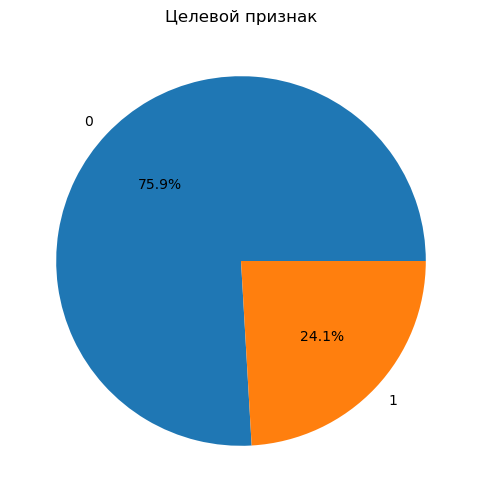

In [12]:
df_to_pie = df[target_feature].value_counts()

plt.figure(figsize=(8, 6))
plt.title('Целевой признак')
plt.pie(df_to_pie.values
        , labels=df_to_pie.index
        , autopct='%.1f%%'
        );

Почти во всех категориальных признаках имеется дисбаланс классов

## 3. Предобработка данных

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataPipeline(BaseEstimator, TransformerMixin):
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        # граничные значения
        self.age_min = None
        self.age_max = None
        self.fnlwgt_min = None
        self.fnlwgt_max = None
        self.education_num_min = None
        self.education_num_max = None
        self.capital_gain_min = None
        self.capital_gain_max = None
        self.capital_loss_min = None
        self.capital_loss_max = None
        self.hours_per_week_min = None
        self.hours_per_week_max = None
                
        # средние значения
        self.age_mean = None
        self.fnlwgt_mean = None
        self.education_num_mean = None
        self.capital_gain_mean = None
        self.capital_loss_mean = None
        self.hours_per_week_mean = None


    def fit(self, df):
        """Сохранение статистик"""

        if 'age' in df.columns:
            self.age_mean = df['age'].mean()
            self.age_min = self.age_mean - 3 * df['age'].std()
            self.age_max = self.age_mean + 3 * df['age'].std()
        if 'fnlwgt' in df.columns:
            self.fnlwgt_mean = df['fnlwgt'].mean()
            self.fnlwgt_min = self.fnlwgt_mean - 3 * df['fnlwgt'].std()
            self.fnlwgt_max = self.fnlwgt_mean + 3 * df['fnlwgt'].std()
        if 'education-num' in df.columns:
            self.education_num_mean = df['education-num'].mean()
            self.education_num_min = self.education_num_mean - 3 * df['education-num'].std()
            self.education_num_max = self.education_num_mean + 3 * df['education-num'].std()
        if 'capital-gain' in df.columns:
            self.capital_gain_mean = df['capital-gain'].mean()
            self.capital_gain_min = self.capital_gain_mean - 3 * df['capital-gain'].std()
            self.capital_gain_max = self.capital_gain_mean + 3 * df['capital-gain'].std()
        if 'capital-loss' in df.columns:
            self.capital_loss_mean = df['capital-loss'].mean()
            self.capital_loss_min = self.capital_loss_mean - 3 * df['capital-loss'].std()
            self.capital_loss_min = self.capital_loss_mean + 3 * df['capital-loss'].std()
        if 'hours-per-week' in df.columns:
            self.hours_per_week_mean = df['hours-per-week'].mean()
            self.hours_per_week_min = self.hours_per_week_mean - 3 * df['hours-per-week'].std()
            self.hours_per_week_max = self.hours_per_week_mean + 3 * df['hours-per-week'].std()

        return self

    def transform(self, df):
        """Трансформация данных"""
        
        if 'age' in df.columns:
            df.loc[(df['age'] > self.age_max) 
                   | (df['age'] < self.age_min), 'age'] = self.age_mean
        if 'fnlwgt' in df.columns:
            df.loc[(df['fnlwgt'] > self.fnlwgt_max) 
                   | (df['fnlwgt'] < self.fnlwgt_min), 'fnlwgt'] = self.fnlwgt_mean
        if 'education-num' in df.columns:
            df.loc[(df['education-num'] > self.education_num_max)
                   | (df['education-num'] < self.education_num_min), 'education-num'] = self.education_num_mean
        if 'capital-gain' in df.columns:
            df.loc[(df['capital-gain'] > self.capital_gain_max)
                    | (df['capital-gain'] < self.capital_gain_min), 'capital-gain'] = self.capital_gain_mean
        if 'capital-loss' in df.columns:
            df.loc[(df['capital-loss'] > self.capital_loss_max)
                    | (df['capital-loss'] < self.capital_loss_min), 'capital-loss'] = self.capital_loss_mean
        if 'hours-per-week' in df.columns:
            df.loc[(df['hours-per-week'] > self.hours_per_week_max)
                    | (df['hours-per-week'] < self.hours_per_week_min), 'hours-per-week'] = self.hours_per_week_mean
           
        return df

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipe = make_pipeline(
    DataPipeline(),
    StandardScaler()
)

cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")          # игнорирование неопознанных данных на тесте или в рабочих данных
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ]
)


In [15]:
X = df[num_features + cat_features]
y = df[target_feature]

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,             # применим из-за дисбаланса классов
                                                    random_state=42)
X_train_orig.shape, X_test_orig.shape

((26048, 14), (6513, 14))

In [16]:
X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

## 4. Обучение модели классификации с целевым признаком `salary`

### 4.1 Построение модели и её обучение

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train_orig)
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)
pred_proba_test = lr.predict_proba(X_test)

### 4.2 Расчет метрик качества обучения модели

<Figure size 1200x1000 with 0 Axes>

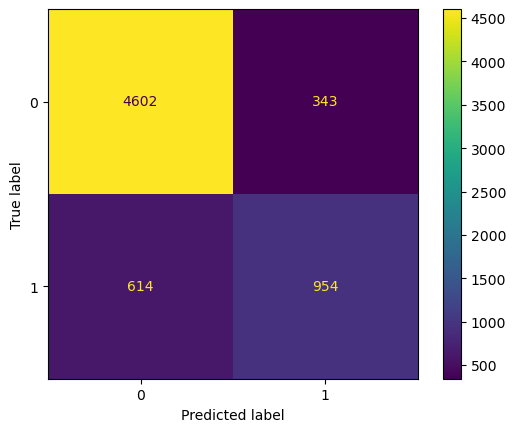

In [18]:
# матрица ошибок
plt.figure(figsize=(12, 10))

cm = confusion_matrix(y_test_orig, pred_test, labels=lr.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
display.plot()
plt.show();

In [19]:
# для train'а
print(classification_report(y_train_orig, pred_train))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     19775
           1       0.73      0.59      0.66      6273

    accuracy                           0.85     26048
   macro avg       0.81      0.76      0.78     26048
weighted avg       0.84      0.85      0.84     26048



In [20]:
# для test'а
print(classification_report(y_test_orig, pred_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4945
           1       0.74      0.61      0.67      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.85      0.85      6513



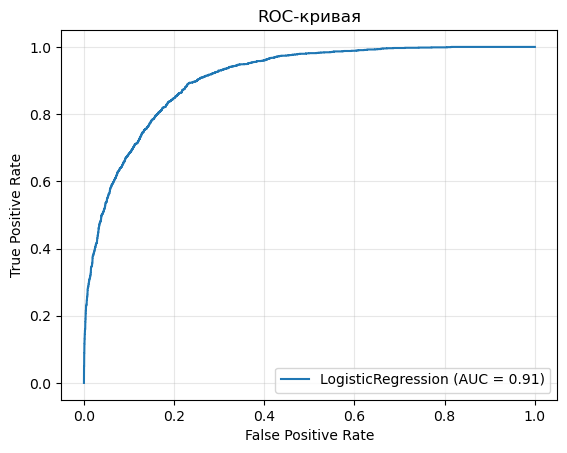

In [21]:
fpr, tpr, thresholds = roc_curve(y_test_orig, pred_proba_test[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr
                          , roc_auc=auc(fpr, tpr)
                          , estimator_name='LogisticRegression')
display.plot()
plt.title('ROC-кривая')
plt.grid(True, alpha=.3)
plt.show()

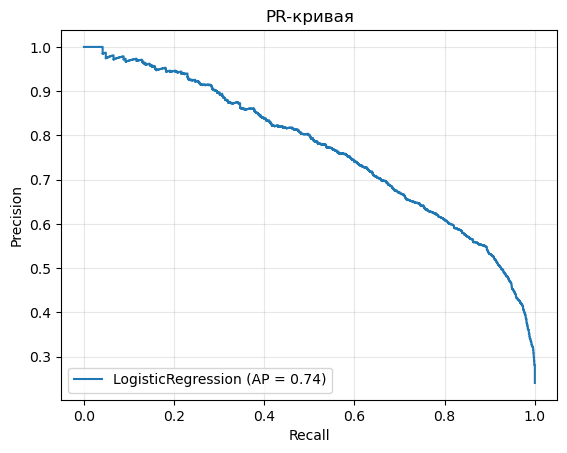

In [22]:
pr, r, _ = precision_recall_curve(y_test_orig, pred_proba_test[:, 1])            # для класса 1

display = PrecisionRecallDisplay(precision=pr, recall=r
                                 , average_precision=precision_score(y_test_orig, pred_test)
                                 , estimator_name='LogisticRegression')
display.plot()
plt.title("PR-кривая")
plt.grid(True, alpha=.3)
plt.show()

## 5. Отбор признаков минимум с помощью трех подходов

### 5.0 Функции-конструкторы новых признаков

In [23]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.count import CountEncoder


def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each)   # бинарное представление категории
        X = pd.concat([X, dummies], axis=1)             # соединияем с исходным дата-фреймом
    return X

def get_label(X, cols):
    X = X.copy()                                        # работаем с копией
    for each in cols:
        le = LabelEncoder()
        labels = le.fit_transform(X[each])               # получаем метки (0, 1, 2 и т.д.) через LabelEncoder
        X[each] = labels
    return X

def get_count(X, cols):
    X = X.copy()

    for col in cols:
        X[col] = X[col].astype('str')

    ce = CountEncoder(handle_unknown=-1)
    ce.fit(X[cols])
    X[cols] = ce.transform(X[cols])
    return X


In [24]:
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [25]:
X = get_one_hot(X, cols=['workclass','marital-status', 'native-country'])
X = get_label(X, cols=['occupation', 'relationship', 'education'])
X = get_count(X, cols=['sex', 'race', 'relationship'])
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,State-gov,9,Never-married,1,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,Self-emp-not-inc,9,Married-civ-spouse,4,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,Private,11,Divorced,6,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,Private,1,Married-civ-spouse,6,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,Private,9,Married-civ-spouse,10,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X = X.drop(columns=cat_features)
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5.1 Одномерный отбор признаков

In [34]:
%%time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=40)
X_new = selector.fit_transform(X, y)
X_new.shape

CPU times: user 59.8 ms, sys: 37.9 ms, total: 97.7 ms
Wall time: 128 ms


(32561, 40)

Отчет о классификации для тренировочных данных:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18539
           1       0.72      0.58      0.64      5881

    accuracy                           0.84     24420
   macro avg       0.80      0.75      0.77     24420
weighted avg       0.84      0.84      0.84     24420


Отчет о классификации для тестовых данных:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.59      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141




<Figure size 1200x1000 with 0 Axes>

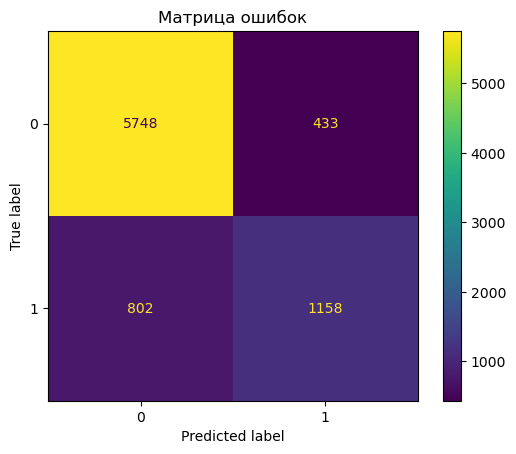

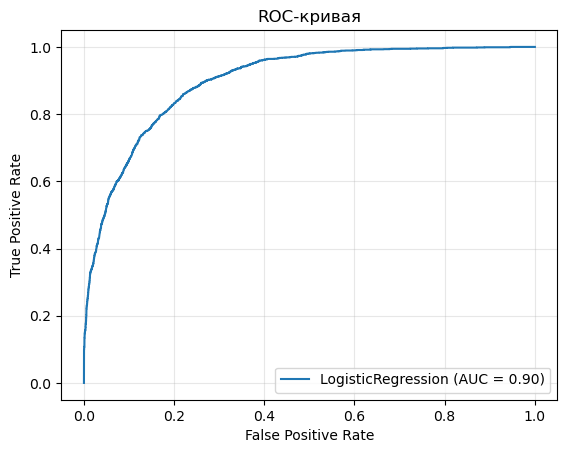

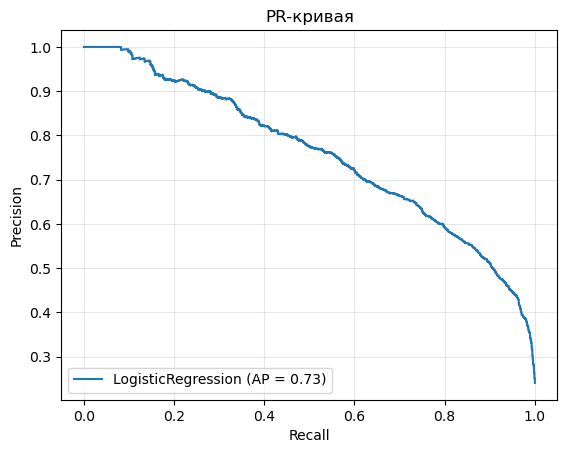

In [35]:
model = get_score(X_new, y, is_return=True)

### 5.2 Рекурсивный отбор признаков

In [36]:
from sklearn.feature_selection import RFE

selector = RFE(model, n_features_to_select=35, step=1)
selector = selector.fit(X_new, y)

In [37]:
X_new2 = selector.transform(X_new)
X_new2.shape

(32561, 30)

Отчет о классификации для тренировочных данных:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     18539
           1       0.67      0.50      0.57      5881

    accuracy                           0.82     24420
   macro avg       0.76      0.71      0.73     24420
weighted avg       0.81      0.82      0.81     24420


Отчет о классификации для тестовых данных:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6181
           1       0.68      0.51      0.58      1960

    accuracy                           0.82      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.81      0.82      0.82      8141




<Figure size 1200x1000 with 0 Axes>

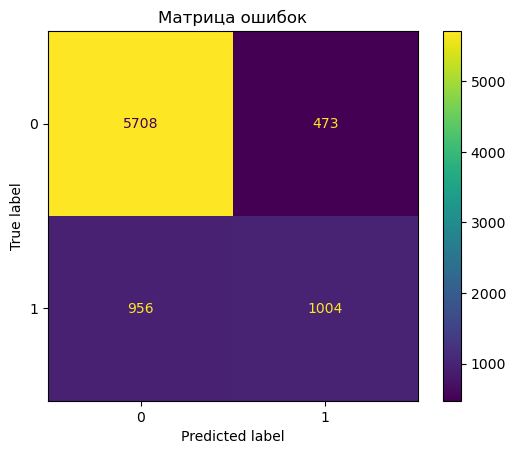

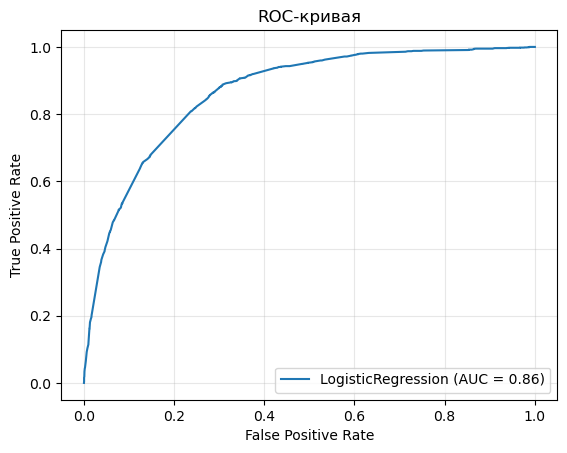

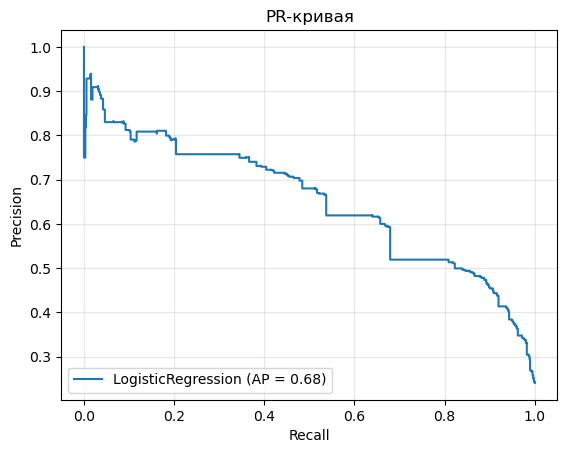

In [38]:
get_score(X_new2, y)

### 5.3 Переборный отбор признаков

In [41]:
%%time
from sklearn.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select='auto', direction="forward"
)
sfs_forward.fit(X_new2, y)

CPU times: user 6min 40s, sys: 11.1 s, total: 6min 51s
Wall time: 5min 6s


SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select='auto')

In [42]:
X_new3 = sfs_forward.transform(X_new2)
X_new3.shape

(32561, 15)

Отчет о классификации для тренировочных данных:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     18539
           1       0.69      0.47      0.56      5881

    accuracy                           0.82     24420
   macro avg       0.77      0.70      0.72     24420
weighted avg       0.81      0.82      0.81     24420


Отчет о классификации для тестовых данных:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      6181
           1       0.69      0.48      0.56      1960

    accuracy                           0.82      8141
   macro avg       0.77      0.70      0.73      8141
weighted avg       0.81      0.82      0.81      8141




<Figure size 1200x1000 with 0 Axes>

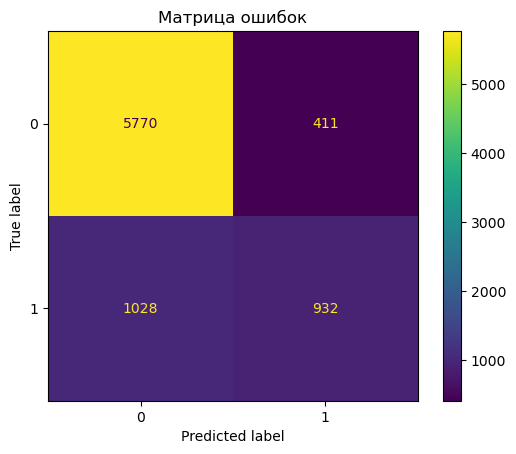

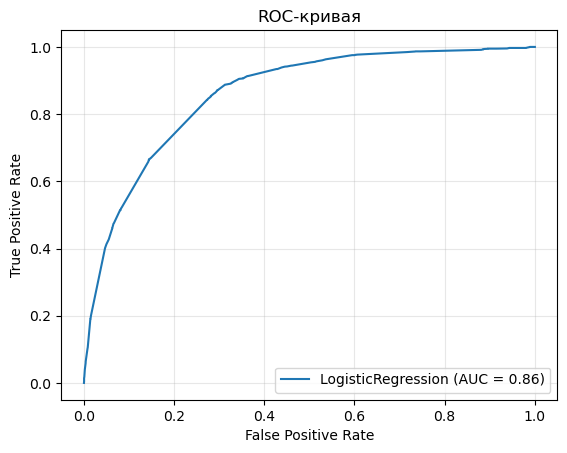

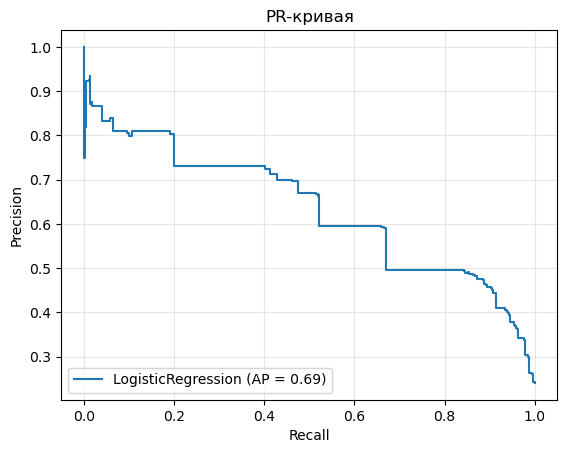

In [43]:
get_score(X_new3, y)

## 6. Выводы о проделанной работе

**Базовое решение:**

F1-score (для теста, макроусреднённая) равна **0.86**. Площадь под ROC-кривой - **0.94**. Средняя точность - **0.76**.

**Решение с балансировкой целевого признака:**

F1-score (для трейна, макроусреднённая) равна **0.96**, F1-score (для теста, макроусреднённая) равна **0.54**, . Площадь под ROC-кривой - **0.97**. Средняя точность - **0.05**.


Модель стала заметно лучше работать на обучающих данных по причине того, что они были сбалансированы, а на тесте показала результаты хуже, поскольку тестовые данные сбалансированы не были